# Finetuning moondream

This notebook demonstrates how to fine-tune moondream to improve performance on a downstream task.
For this example, we'll fine-tune on the [Deep fashion](https://huggingface.co/datasets/Marqo/deepfashion-multimodal) dataset.

In [1]:
%pip install torch transformers timm einops datasets bitsandbytes accelerate flash_attn

In [2]:
from torch.utils.data import Dataset
from datasets import load_dataset
from sklearn.model_selection import train_test_split

class DeepFashionDataset(Dataset):
    def __init__(self, split='train', test_size=0.2, random_state=42, data_percentage=1.0):
        # Load the entire dataset
        self.data = load_dataset("Marqo/deepfashion-multimodal")['data']

        # Calculate the number of samples to use based on the data_percentage
        n_samples = int(len(self.data) * data_percentage)
        if n_samples < 1:
            raise ValueError("data_percentage results in too few samples. Increase the percentage.")

        # Use only the specified percentage of the data
        self.data = self.data.select(list(range(n_samples)))

        # Split the dataset into train and test based on the test_size
        train_indices, test_indices = train_test_split(
            list(range(len(self.data))), test_size=test_size, random_state=random_state
        )

        # Select the appropriate split
        if split == 'train':
            self.data = self.data.select(train_indices)
        elif split == 'test':
            self.data = self.data.select(test_indices)
        else:
            raise ValueError("split must be 'train' or 'test'")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        return {
            "image": sample["image"],  # Assuming 'image' contains the visual input
            "qa": [
                {
                    "question": "What is the person wearing?",
                    "answer": sample["text"],  # Assuming 'text' contains the description/caption
                }
            ]
        }

# Create training and testing datasets with a 80-20 split and 5% of the data
datasets = {
    "train": DeepFashionDataset(split="train", data_percentage=0.05),
    "test": DeepFashionDataset(split="test", data_percentage=0.05),
}

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Now let's take a look at a sample image from the training set and compare the ground-truth answers
with moondream predictions.

In [3]:
# Initialize moondream. Change DEVICE to 'mps' if you're on an M1 Mac, or 'cpu' if you don't have a
# GPU. Note that fine-tuning on CPU will be very slow.

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

DEVICE = "cuda"
DTYPE = torch.float32 if DEVICE == "cpu" else torch.float16 # CPU doesn't support float16
MD_REVISION = "2024-08-26"

tokenizer = AutoTokenizer.from_pretrained("vikhyatk/moondream2", revision=MD_REVISION)
moondream = AutoModelForCausalLM.from_pretrained(
    "vikhyatk/moondream2", revision=MD_REVISION, trust_remote_code=True,
    # attn_implementation="flash_attention_2" if DEVICE == "cuda" else None,
    torch_dtype=DTYPE, device_map={"": DEVICE}
)

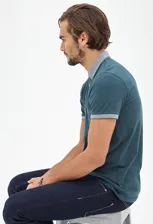

Question: What is the person wearing?
Ground Truth: This gentleman wears a short-sleeve T-shirt with solid color patterns. The T-shirt is with cotton fabric and its neckline is lapel. There is an accessory on his wrist.
Moondream: The person is wearing a green polo shirt.


In [4]:
from IPython.display import display

sample = datasets['train'][0]
display(sample['image'])

for qa in sample['qa']:
    print('Question:', qa['question'])
    print('Ground Truth:', qa['answer'])
    print('Moondream:', moondream.answer_question(
        moondream.encode_image(sample['image']),
        qa['question'],
        tokenizer=tokenizer,
    ))

Let's start setting up hyperparameters for finetuning.

In [5]:
# Number of times to repeat the training dataset. Increasing this may cause the model to overfit or
# lose generalization due to catastrophic forgetting. Decreasing it may cause the model to underfit.
EPOCHS = 1

# Number of samples to process in each batch. Set this to the highest value that doesn't cause an
# out-of-memory error. Decrease it if you're running out of memory.
BATCH_SIZE = 8

# Number of batches to process before updating the model. You can use this to simulate a higher batch
# size than your GPU can handle. Set this to 1 to disable gradient accumulation.
GRAD_ACCUM_STEPS = 2

# Learning rate for the Adam optimizer. Needs to be tuned on a case-by-case basis. As a general rule
# of thumb, increase it by 1.4 times each time you double the effective batch size.
#
# Source: https://www.cs.princeton.edu/~smalladi/blog/2024/01/22/SDEs-ScalingRules/
#
# Note that we linearly warm the learning rate up from 0.1 * LR to LR over the first 10% of the
# training run, and then decay it back to 0.1 * LR over the last 90% of the training run using a
# cosine schedule.
LR = 1e-5

# Whether to use Weights and Biases for logging training metrics.
USE_WANDB = False


This next block will start the training process.

In [6]:
from torch.utils.data import DataLoader
from bitsandbytes.optim import Adam8bit
import math
from einops import rearrange
from tqdm import tqdm

ANSWER_EOS = "<|endoftext|>"

# Number of tokens used to represent each image.
IMG_TOKENS = 729

def collate_fn(batch):
    images = [sample['image'] for sample in batch]
    images = [moondream.vision_encoder.preprocess(image) for image in images]

    labels_acc = []
    tokens_acc = []

    for sample in batch:
        toks = [tokenizer.bos_token_id]
        labs = [-100] * (IMG_TOKENS + 1)

        for qa in sample['qa']:
            q_t = tokenizer(
                f"\n\nQuestion: {qa['question']}\n\nAnswer:",
                add_special_tokens=False
            ).input_ids
            toks.extend(q_t)
            labs.extend([-100] * len(q_t))

            a_t = tokenizer(
                f" {qa['answer']}{ANSWER_EOS}",
                add_special_tokens=False
            ).input_ids
            toks.extend(a_t)
            labs.extend(a_t)

        tokens_acc.append(toks)
        labels_acc.append(labs)

    max_len = -1
    for labels in labels_acc:
        max_len = max(max_len, len(labels))

    attn_mask_acc = []

    for i in range(len(batch)):
        len_i = len(labels_acc[i])
        pad_i = max_len - len_i

        labels_acc[i].extend([-100] * pad_i)
        tokens_acc[i].extend([tokenizer.eos_token_id] * pad_i)
        attn_mask_acc.append([1] * len_i + [0] * pad_i)

    return (
        images,
        torch.stack([torch.tensor(t, dtype=torch.long) for t in tokens_acc]),
        torch.stack([torch.tensor(l, dtype=torch.long) for l in labels_acc]),
        torch.stack([torch.tensor(a, dtype=torch.bool) for a in attn_mask_acc]),
    )

def compute_loss(batch):
    images, tokens, labels, attn_mask = batch

    tokens = tokens.to(DEVICE)
    labels = labels.to(DEVICE)
    attn_mask = attn_mask.to(DEVICE)

    with torch.no_grad():
        img_embs = moondream.vision_encoder(images)

    tok_embs = moondream.text_model.get_input_embeddings()(tokens)
    inputs_embeds = torch.cat((tok_embs[:, 0:1, :], img_embs, tok_embs[:, 1:, :]), dim=1)

    outputs = moondream.text_model(
        inputs_embeds=inputs_embeds,
        labels=labels,
        attention_mask=attn_mask,
    )

    return outputs.loss

def lr_schedule(step, max_steps):
    x = step / max_steps
    if x < 0.1:
        return 0.1 * LR + 0.9 * LR * x / 0.1
    else:
        return 0.1 * LR + 0.9 * LR * (1 + math.cos(math.pi * (x - 0.1))) / 2

dataloaders = {
    "train": DataLoader(
        datasets["train"],
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=collate_fn,
    )
}

moondream.text_model.train()
moondream.text_model.transformer.gradient_checkpointing_enable()

total_steps = EPOCHS * len(dataloaders["train"]) // GRAD_ACCUM_STEPS
optimizer = Adam8bit(
    [
        {"params": moondream.text_model.parameters()},
    ],
    lr=LR * 0.1,
    betas=(0.9, 0.95),
    eps=1e-6
)

if USE_WANDB:
    import wandb
    wandb.init(
        project="moondream-ft",
        config={
            "EPOCHS": EPOCHS,
            "BATCH_SIZE": BATCH_SIZE,
            "GRAD_ACCUM_STEPS": GRAD_ACCUM_STEPS,
            "LR": LR,
        }
    )

i = 0
for epoch in range(EPOCHS):
    for batch in tqdm(dataloaders["train"], desc=f"Epoch {epoch + 1}/{EPOCHS}"):
        i += 1

        loss = compute_loss(batch)
        loss.backward()

        if i % GRAD_ACCUM_STEPS == 0:
            optimizer.step()
            optimizer.zero_grad()

            lr = lr_schedule(i / GRAD_ACCUM_STEPS, total_steps)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr

        if USE_WANDB:
            wandb.log({
                "loss/train": loss.item(),
                "lr": optimizer.param_groups[0]['lr']
            })

if USE_WANDB:
    wandb.finish()

Epoch 1/1:   0%|          | 0/213 [00:00<?, ?it/s]WARNING:transformers_modules.vikhyatk.moondream2.92d3d73b6fd61ab84d9fe093a9c7fd8c04bf2c0d.modeling_phi:`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
Epoch 1/1: 100%|██████████| 213/213 [16:01<00:00,  4.51s/it]


In [9]:
moondream.save_pretrained("checkpoints/moondream-ft")

Now that training has completed, let's inspect a few samples and calculate accuracy.

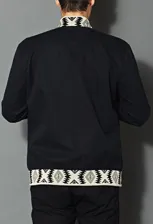

Question: What is the person wearing?
Ground Truth: The shirt this guy wears has long sleeves and it is with denim fabric and solid color patterns. The outer clothing this man wears is with cotton fabric and solid color patterns.
Moondream: The upper clothing has long sleeves, cotton fabric and graphic patterns. The neckline of it is lapel.


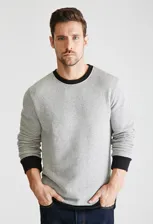

Question: What is the person wearing?
Ground Truth: The upper clothing has long sleeves, cotton fabric and solid color patterns. It has a round neckline.
Moondream: This gentleman is wearing a long-sleeve sweater with pure color patterns. The sweater is with cotton fabric and its neckline is round.


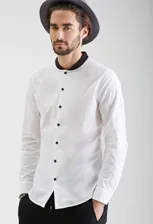

Question: What is the person wearing?
Ground Truth: The upper clothing has long sleeves, cotton fabric and pure color patterns. It has a stand neckline. The gentleman is wearing a hat. There is an accessory on his wrist.
Moondream: The gentleman wears a long-sleeve shirt with pure color patterns. The shirt is with cotton fabric. It has a lapel neckline. The gentleman wears a hat.


In [10]:
moondream.eval()

for i, sample in enumerate(datasets['test']):
    md_answer = moondream.answer_question(
        moondream.encode_image(sample['image']),
        sample['qa'][0]['question'],
        tokenizer=tokenizer,
        num_beams=4,
        no_repeat_ngram_size=5,
        early_stopping=True
    )

    if i < 3:
        display(sample['image'])
        print('Question:', sample['qa'][0]['question'])
        print('Ground Truth:', sample['qa'][0]['answer'])
        print('Moondream:', md_answer)
    else:
        break
